# CHURN IN TELCO INDUSTRY

Prediction of churn in Telecom industry

Classification problem

Dataset from: https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset

#### Description of variables:
* state: the state the user lives in
* account length: the number of days the user has this account
* area code: the code of the area the user lives in
* phone number: the phone number of the user
* international plan: true if the user has the international plan, otherwise false
* voice mail plan: true if the user has the voice mail plan, otherwise false
* number vmail messages: the number of voice mail messages the user has sent
* total day minutes: total number of minutes the user has been in calls during the day
* total day calls: total number of calls the user has done during the day
* total day charge: total amount of money the user was charged by the Telecom company for calls during the day
* total eve minutes: total number of minutes the user has been in calls during the evening
* total eve calls: total number of calls the user has done during the evening
* total eve charge: total amount of money the user was charged by the Telecom company for calls during the evening
* total night minutes: total number of minutes the user has been in calls during the night
* total night calls: total number of calls the user has done during the night
* total night charge: total amount of money the user was charged by the Telecom company for calls during the night
* total intl minutes: total number of minutes the user has been in international calls
* total intl calls: total number of international calls the user has done
* total intl charge: total amount of money the user was charged by the Telecom company for international calls
* customer service calls: number of customer service calls the user has done
* churn: true if the user terminated the contract, otherwise false

## 1. Importing needed libraries, setting options 

In [1]:
import sklearn
print(sklearn.__version__)

1.1.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, MinMaxScaler  

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.feature_selection import chi2, SelectKBest, RFE, SelectFromModel, SelectPercentile

from sklearn.utils import resample

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, \
                            recall_score, roc_auc_score, precision_score, recall_score

from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

import xgboost as xgb

### Setting options

In [113]:
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', None)

## Making own functions

### Functions to print basic info about dataset

In [4]:
def unique_col(data):
    print("How many unique value have each columns:")
    for col in data.columns:
        print(f"- {col.upper()}:  {data[col].nunique()}. This is {round(data[col].nunique() / data.shape[0] ,3)}% of data")

def null_value(data):
    col_with_null = []
    count = 0
    for col in data.columns:
        null = data[col].isnull().sum()
        if null > 0:
            col_with_null.append(col)
        if data[col].notnull().sum() != data.shape[0]:
            count += 1
    if count != 0:
        response = 'Yes'
    else:
        response = 'No'
    return col_with_null, response

def column_to_delete(data):
    """Print list of columns which have only unique value"""
    col_to_delete = []
    for col in data.columns:
        if (data[col].nunique() / data.shape[0]) == 1:
            col_to_delete.append(col)
    return col_to_delete

def return_categorical(data):

    cat_col = [col_name for col_name in data if data[col_name].dtype == 'O']
    return cat_col


def return_numeric(data):

    num_col = [col_name for col_name in data if data[col_name].dtype != 'O']
    return num_col
    
def print_basic_info(data, target, threshold):
    """
    This function print basic info about dataset which has only to classes to predict.
    Parameters:
    > data: our dataset,
    > target: which column we want to predict,
    > threshold: how many % we consider our data to be inbalance.
    """
    data_y = data[target]
    y = round((data_y.sum() / data_y.shape[0])* 100 ,2)
    col_with_null, response = null_value(data)
    num_col = return_numeric(data)
    cat_col = return_categorical(data)
    col_to_delete = column_to_delete(data)
    
    if y < threshold:
        data_unbalanced = 'Yes'
    else: 
        data_unbalanced = 'No'
    
    print("BASIC INFORMATION ABOUT THE DATASET \n")
    print("--------------------------------------------------------------------------")
    print(f"Number of row: {data.shape[0]}, number of columns {data.shape[1]} \n")
    print("--------------------------------------------------------------------------")
    print(f"Is there null values: {response} \n")
    print(f"Columns with null values: {col_with_null} \n")   
    print("--------------------------------------------------------------------------")
    print(f"Categorical columns: {cat_col} \n") 
    print(f"Numeric columns: {num_col} \n") 
    print(f"{unique_col(data)} \n")
    print("--------------------------------------------------------------------------")
    print(f"Is dataset unbalaced? {data_unbalanced}. \nPercentage of clients who made churn is: {y}% \n")
    print(f"Columns to delete because they contains only unique value: {col_to_delete}")

###  Functions for basic preprocess data

In [5]:
def basic_preprocess(data, target, col_to_drop: list = None, plot_corr='no', divide='no'):
    """
    Parameters:
    > data: our dataset
    > target: our prediction column
    > col_to_drop: columns to drop from dataset - names of columns need to be put into a list
    > plot_corr: if we want to plot corellation matrix from our data. Default='no'  ['no', 'yes']
    > divide: if we want to divide our data into X and y data. Default='no' ['no', 'yes']
    
    This function makes categorical column into numeric with LabelEncoder, divide data 
    into 2 set: X, y and plot correlation matrix after dropping wanted columns.
    """
    if col_to_drop:
        data = data.drop(col_to_drop, axis=1)
    
    cat_col = [col for col in data.columns if data[col].dtype in ['bool', 'object']]
    
    encoder = LabelEncoder()
    for i in cat_col:
        encoder.fit(data[i])
        data[i] = encoder.transform(data[i])
    
    if plot_corr == 'yes':
        f, ax = plt.subplots(figsize=(20, 20))
        sns.heatmap(data.corr(method='pearson'), square=True, annot = True)
        plt.title("Correlation map", fontsize=12)
        plt.show()
    
    if divide == 'no':
        return data
    elif divide == 'yes':
        data_y = data.pop(target)
        data_X = data
        return data_X, data_y

def col_to_drop_after_high_corr(data, threshold):
    """
    Parameters:
    > data: our dataset
    > threshold: % above which we want to remove our columns
    This function delete from our dataset columns with high correlation which we can manually choose.
    """
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

### Functions for selecting features

In [6]:
def data_after_pca(X_norm):
    pca = PCA(0.95)
    pca.fit(X_norm)
    X_pca = pca.transform(X_norm)
    n_components = len(pca.explained_variance_ratio_.cumsum())
    X_pca = pd.DataFrame(X_pca, columns=["PC#%d" % (x + 1) for x in range(n_components)])
    return X_pca

def pearson_cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print('Pearson correlation:', str(len(cor_feature)), 'selected features')
    return cor_support, cor_feature

def chi_square_selector(X, y, preprocessor, num_feats):
    X_norm = preprocessing(X, preprocessor)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print('Chi-square:', str(len(chi_feature)), 'selected features')
    return chi_support, chi_feature

def rfe_selector(X, y, preprocessor, num_feats):
    X_norm = preprocessing(X, preprocessor)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print('RFE:', str(len(rfe_feature)), 'selected features')
    return rfe_support, rfe_feature

def lr_lasso_selector(X, y, preprocessor, num_feats):
    X_norm = preprocessing(X, preprocessor)
    lr_l2_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    lr_l2_selector.fit(X_norm, y)
    lr_l2_support = lr_l2_selector.get_support()
    lr_l2_feature = X.loc[:,lr_l2_support].columns.tolist()
    print('Lasso:', str(len(lr_l2_feature)), 'selected features')
    return lr_l2_support, lr_l2_feature

def tree_selector(X, y, num_feats):
    tree_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    tree_selector.fit(X, y)
    tree_support = tree_selector.get_support()
    tree_feature = X.loc[:,tree_support].columns.tolist()
    print('Tree:', str(len(tree_feature)), 'selected features')
    return tree_support, tree_feature

def print_feature_summary(feature_name, cor_support, chi_support, rfe_support, l2_support, tree_support):
    # put all selection together
    feature_selection_df = pd.DataFrame({'Feature':feature_name, 
                                         'Pearson':cor_support, 
                                         'Chi-2':chi_support, 
                                         'RFE':rfe_support, 
                                         'Logistics':l2_support,
                                         'Random Forest':tree_support})
    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    print("Name of this dataframe: 'feature_selection_df'")
    return feature_selection_df#.head(num_feats)

### Functions for transforming data

In [7]:
def preprocessing(X, preprocessor=None):
    if preprocessor is not None:
        preprocessor.fit(X.values)
        X_preprocessed = X.copy()
        X_preprocessed[:] = preprocessor.transform(X.values)
        X = X_preprocessed
    return X

In [8]:
def resample_data(data, target, col_to_drop:list = None):
    df = basic_preprocess(data=data, target=target, cor='no', col_to_drop=col_to_drop, divide='no')
    df_0 = df[df[target] == 0 ]
    df_1 = df[df[target] == 1 ]
    n_y = len(df[df[target] == 1 ])
    df_0_downsample = resample(df_0, 
                               replace = True,    
                               n_samples = 2*n_y,    
                               random_state = 42)
    df_1_upsample = resample(df_1, 
                               replace = True,    
                               n_samples = round(1.1*n_y),    
                               random_state = 42)
    data_resmaple = pd.concat([df_0_downsample, df_1_upsample])
    
    y = data_resmaple.pop(target)
    X = data_resmaple
    print(f"New dataset after resampling has: {data_resmaple.shape[0]} rows")
    return y, X

### Functions to build pipeline for many models

In [9]:
def find_best_option(model, X_train, y_train, params=None, balance=None, best_models=None):
    
    if best_models == None:
        if balance == None:
            pipeline = Pipeline([('clf', model)])
        else:
            pipeline = Pipeline([('sm', balance), ('clf', model)])

        gs = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='f1', return_train_score=True)
        gs.fit(X_train, y_train)
        return gs
    else:
        optimizer = GridSearchCV(model, 
                                 param_grid=params, 
                                 cv=5, 
                                 scoring="f1",
                                 n_jobs=-1)
        optimizer.fit(X_train, y_train)
        return optimizer

In [134]:
def looking_for_parameters(X, y, models, params, models_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
    metrics_value = []

    for model, param, name in zip(models, params, models_name):
        print(f"Looking for best parameters for {name}")
        optimizer = find_best_option(model=model, X_train=X_train, y_train=y_train, best_models='yes', params=param) 
        best_param = optimizer.best_params_
        target = y_test
        prediction = optimizer.predict(X_test)
        accuracy, precision, recall, f1, mislabeled, total =  calculate_metrics(target, prediction, average='macro')
        metrics_value.append({
            'model_name': name,
            'best_params': best_param,
            'accuracy': round(accuracy,2),
            'precision': round(precision,2),
            'recall': round(recall,2),
            'f1': round(f1,2),
            'mislabeled': mislabeled,
            'total': total
        })
        print("Done!")
    df_metrics_value = pd.DataFrame(metrics_value, columns=['model_name', 'best_params', 'accuracy','precision'\
                                                           'recall', 'f1', 'mislabeled', 'total'])
    df_metrics_value = df_metrics_value.sort_values(by ='f1', ascending=False)
    df_metrics_value = df_metrics_value.style.set_properties(subset=['best_params'], **{'width': '320px'})
    
    return df_metrics_value

### Functions for visualization

In [10]:
def plot_countplot(df, feature, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    sns.countplot(x=df[feature], order = df[feature].value_counts().index, palette='Set3')
    plt.title(title, fontsize=16)
    if(size > 5):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

In [11]:
def plot_hist_box(columns):
    columns = columns
    
    for col in columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))    
        ax1.hist(data[col], bins=25)
        ax1.set_xlim(0, max(data[col]))
        ax2.boxplot(data[col])
        fig.suptitle(col, fontsize=16);

In [12]:
def compare_with_target(columns):
    columns = columns
    
    for col in columns:
        plt.figure(figsize=(15,6))
        sns.countplot(x=col, data=data, hue='churn')
        plt.title(col, fontsize=20);
    
        print(col.upper())
        print((pd.DataFrame(data.groupby(col).churn.value_counts(normalize=True))).T)
        print('-------------------------------------')
        print()

In [13]:
def corr_plot(data, target):
    corr = data.corr()[target]

    corr.plot.bar(figsize=(14,5));
    for i in range(len(corr)):
        plt.text(i, corr[i], round(corr[i],3), ha='center', va='bottom')
    plt.title(f"Correletion with {target}", fontsize = 16);

In [66]:
def target_in_outliers(columns, target):
    print("What % of distribution the target in outliers has in given columns: \n")
    outliers_value = []
    for col in columns:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1 
        fence_low = q1 - (1.5 * iqr)
        fence_high = q3 + (1.5 * iqr)
        outliers_value.append({'columns': col,
                               'fence_low': fence_low,
                               'fence_high': fence_high})
        print(col.upper())
        print(data[(data[col] > fence_high) | (data[col] < fence_low)][target].value_counts(normalize=True))
        print('-------------------------------------')
    df_outliers_value = pd.DataFrame(outliers_value, columns=['columns', 'fence_low', 'fence_high'])
    return df_outliers_value

### Function for cross val score method

In [14]:
def cvs_scores_to_df(clf, scoring, threshold, folds, standarizer=StandardScaler()):
    """ 
    This function takes:
    < dict: with names of models and models,
    < scoring: which indicates methods for scoring the models through process of cross validation,
    < threshold: which indicate max different within models to accept them as not offerfitting,
    < standarizer: takes one of the function which standarize data. Default: StandardScaler.
    And return dataframe which conteins name of models, mean, min, max value from cross validation each of the given models.
    """
    scores = []
    
    for name, model in clf.items(): 
        pipe = make_pipeline(standarizer, model)
        cvs_score = cross_val_score(pipe, X, y, cv=folds, scoring=scoring)
        if max(cvs_score) - min(cvs_score) > threshold:
            overfitting = 'Yes'
        else:
            overfitting = 'No' 
        scores.append({
            'model': name,
            'mean': cvs_score.mean(),
            'min': (min(cvs_score)),
            'max': (max(cvs_score)),
            'overfitting': overfitting
        })
    
    df_cv_scores = pd.DataFrame(scores, columns=['model', 'mean', 'min', 'max', 'overfitting'])
    print(f"This function made dataframe with scores from different models through cross validation using {scoring} to score models.")
    return df_cv_scores

### Functions to create metrics for models

In [15]:
def create_measures(y,y_pred): 
    score_test = roc_auc_score(y, y_pred)
    Gini_index = 2*score_test - 1
    
    d = {'AUC': [round(score_test,4)], 'GINI': [round(Gini_index,4)]}
    d = pd.DataFrame.from_dict(d)
    
    return d

def calculating_metrics(X_train, X_test, y_train, y_test):
    train = create_measures(y_train,model.predict_proba(X_train)[:, 1])
    test = create_measures(y_test,model.predict_proba(X_test)[:, 1])
    
    measures =  pd.concat([train,test]).set_index([pd.Index(['TRAIN', 'TEST'])]) 
    
    return measures

In [16]:
def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

## 2. Importing data

In [74]:
data = pd.read_csv("bigml_59c28831336c6604c800002a.csv")

In [75]:
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 3. Basic information and metrics about dataset

In [76]:
print(f"Dataset basic information: \n")
data.info()

Dataset basic information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night

In [77]:
print(f"Basic statistic for numerical variable:")
data.describe().T

Basic statistic for numerical variable:


,count,mean,std,min,25%,50%,75%,max
account length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
area code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
number vmail messages,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
total day minutes,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
total day calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
total day charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
total eve minutes,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
total eve calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00
total eve charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91
total night minutes,3333.0,200.872037,50.573847,23.20,167.00,201.20,235.30,395.00


In [78]:
print_basic_info(data, 'churn', 35)

BASIC INFORMATION ABOUT THE DATASET 

--------------------------------------------------------------------------
Number of row: 3333, number of columns 21 

--------------------------------------------------------------------------
Is there null values: No 

Columns with null values: [] 

--------------------------------------------------------------------------
Categorical columns: ['state', 'phone number', 'international plan', 'voice mail plan'] 

Numeric columns: ['account length', 'area code', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'churn'] 

How many unique value have each columns:
- STATE:  51. This is 0.015% of data
- ACCOUNT LENGTH:  212. This is 0.064% of data
- AREA CODE:  3. This is 0.001% of data
- PHONE NUMBER:  333

### Conclusion about first check: 
1) There is no null value so we don't have to handle missing value

2) The dataset have 21 columns so we can try select best feature for models - feature selection

3) The data will have to be standardized

4) Variable: PHONE NUMBER have only unique values so we can remove it from dataset

5) Dataset is unbalanced, and members with churn is only 14,49% of all dataset so it will be usufull to try some resample data or use some methods for this problem like smote

### Next step:
* drop unnecesary columns
* divide data in X and y (optional at this stage)
* change prediction column in numeric type.
* divide columns in numeric and categorical -> categorical value invert into numeric by LabelEncoder or OneHotEncoder
* check corellation in the dataset

## 4. Visualization and correlation

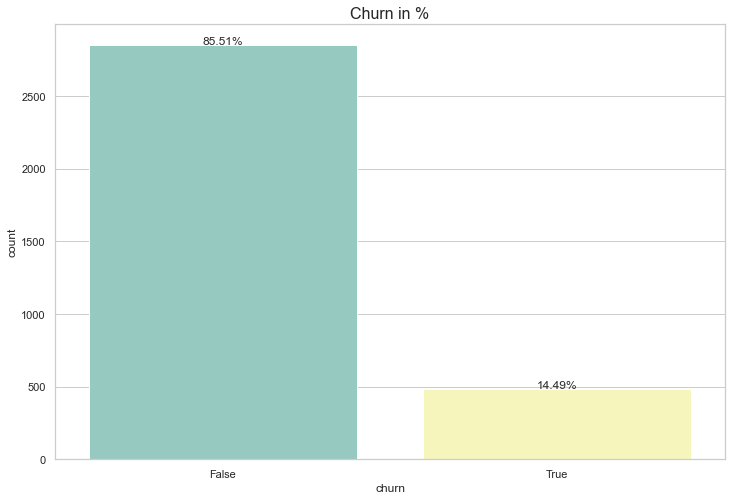

In [79]:
plot_countplot(data, 'churn', 'Churn in %', size=4)

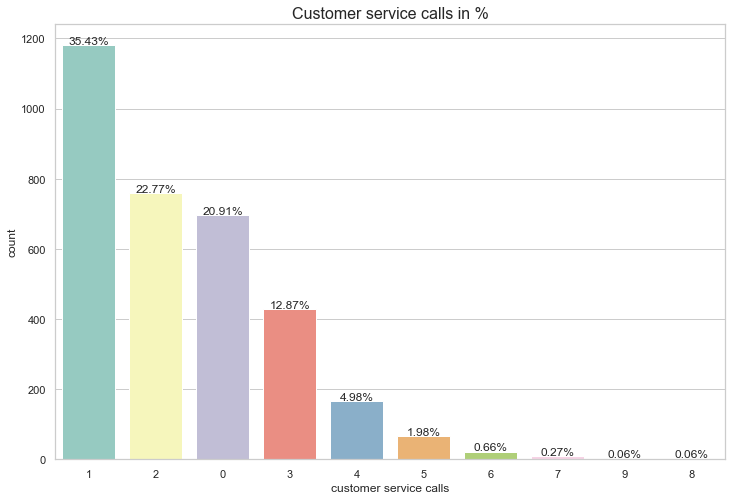

In [80]:
plot_countplot(data, 'customer service calls', 'Customer service calls in %', size=4)

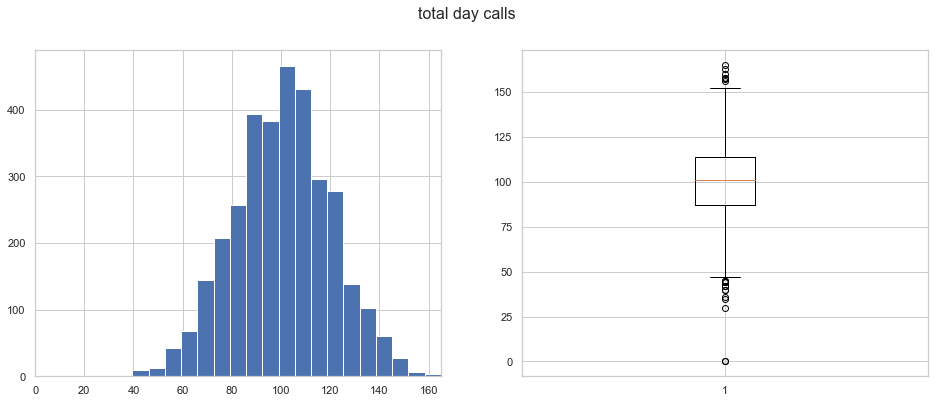

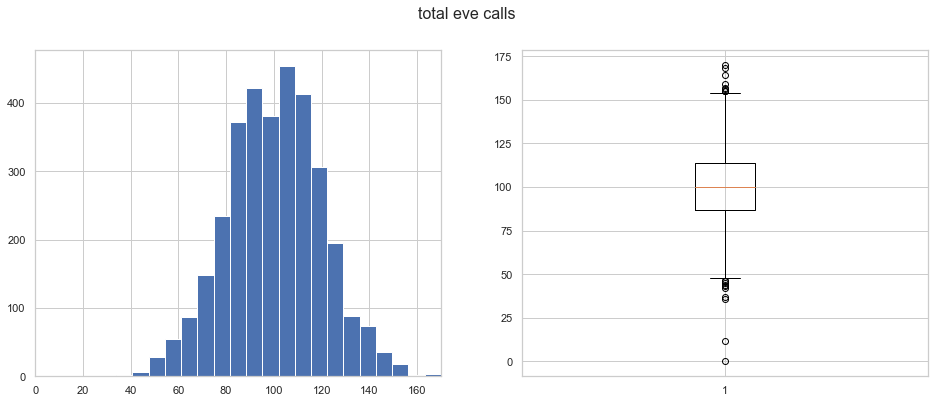

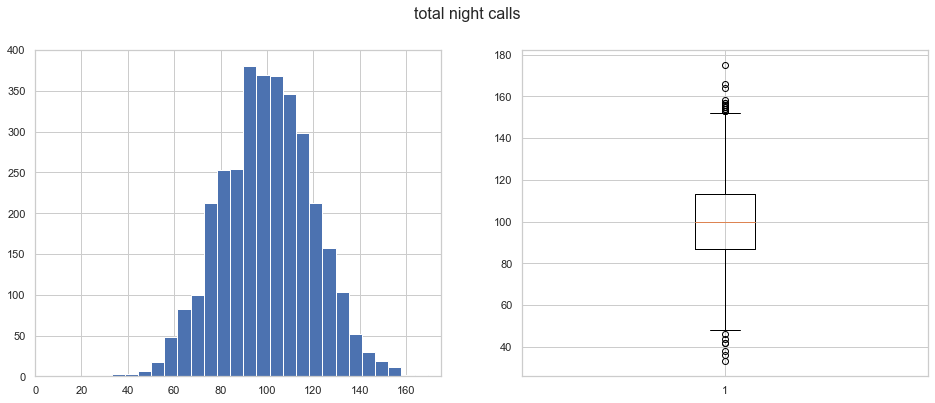

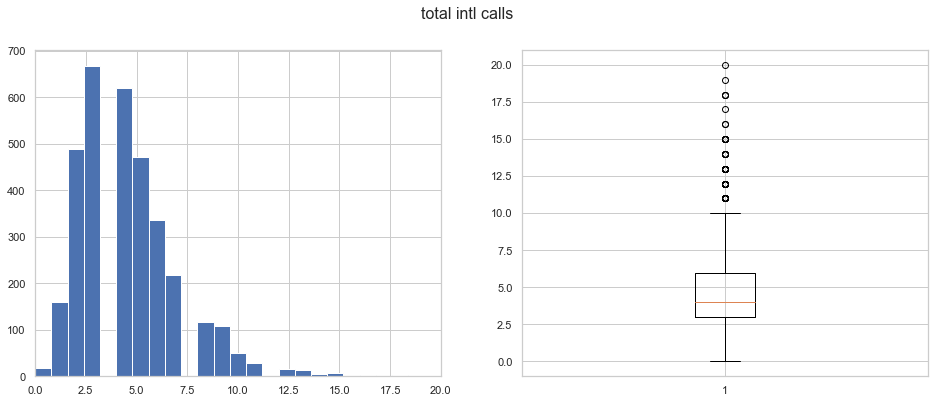

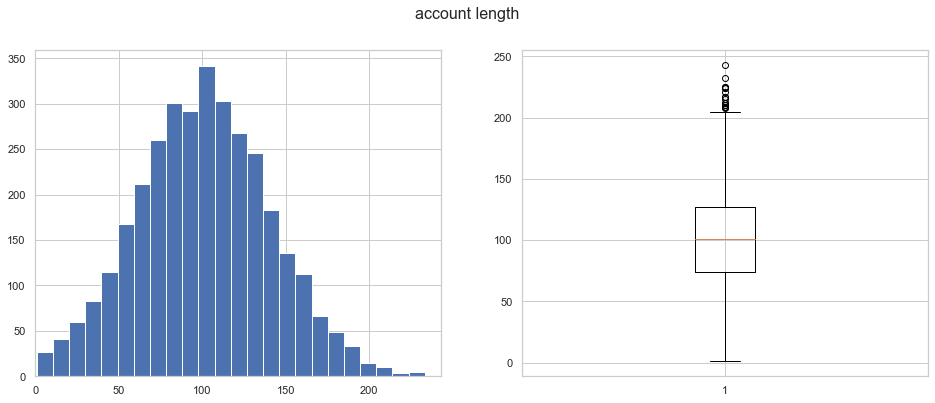

In [81]:
my_columns = ['total day calls','total eve calls','total night calls','total intl calls', 'account length']
plot_hist_box(my_columns)

In [82]:
outliers_columns = ['total day calls','total eve calls','total night calls','total intl calls', 'account length']
outliers_value = target_in_outliers(outliers_columns, 'churn')
outliers_value

What % of distribution the target in outliers has in given columns: 

TOTAL DAY CALLS
False    0.695652
True     0.304348
Name: churn, dtype: float64
-------------------------------------
TOTAL EVE CALLS
False    0.9
True     0.1
Name: churn, dtype: float64
-------------------------------------
TOTAL NIGHT CALLS
False    0.954545
True     0.045455
Name: churn, dtype: float64
-------------------------------------
TOTAL INTL CALLS
False    0.858974
True     0.141026
Name: churn, dtype: float64
-------------------------------------
ACCOUNT LENGTH
False    0.722222
True     0.277778
Name: churn, dtype: float64
-------------------------------------


,columns,fence_low,fence_high
0,total day calls,46.5,154.5
1,total eve calls,46.5,154.5
2,total night calls,48.0,152.0
3,total intl calls,-1.5,10.5
4,account length,-5.5,206.5


STATE
state        AK              AL         AR           AZ                CA  \
churn     False      True False True False True   False    True     False   
churn  0.942308  0.057692   0.9  0.1   0.8  0.2  0.9375  0.0625  0.735294   

state            ...        VT                  WA                  WI  \
churn      True  ...     False      True     False      True     False   
churn  0.264706  ...  0.890411  0.109589  0.787879  0.212121  0.910256   

state                 WV                 WY            
churn      True    False     True     False      True  
churn  0.089744  0.90566  0.09434  0.883117  0.116883  

[1 rows x 102 columns]
-------------------------------------

AREA CODE
area code       408                 415                510         
churn         False      True     False      True    False     True
churn      0.854415  0.145585  0.857402  0.142598  0.85119  0.14881
-------------------------------------

INTERNATIONAL PLAN
international plan       no         

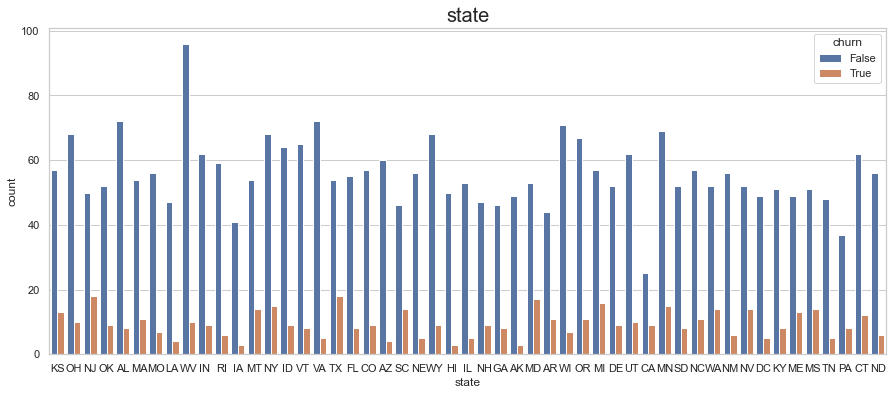

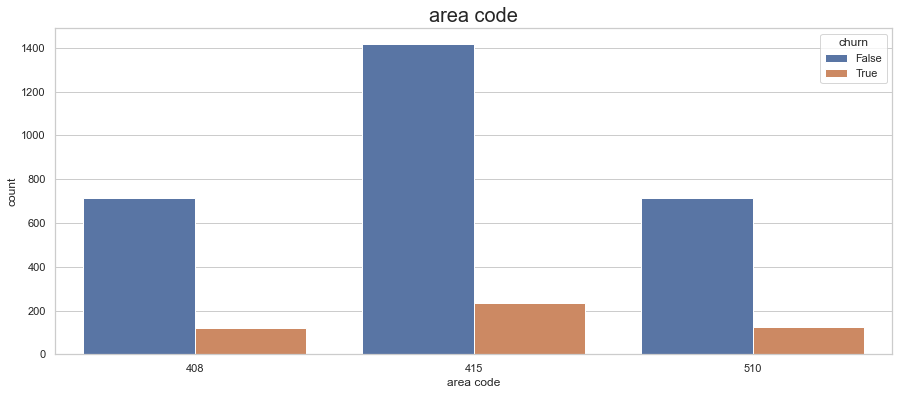

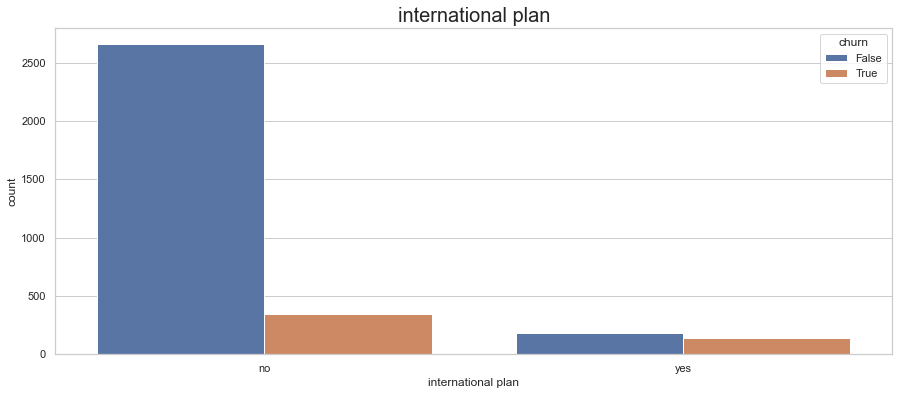

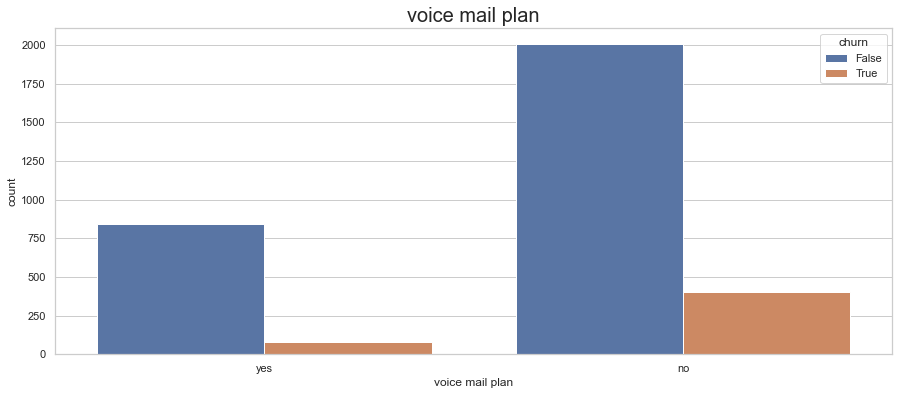

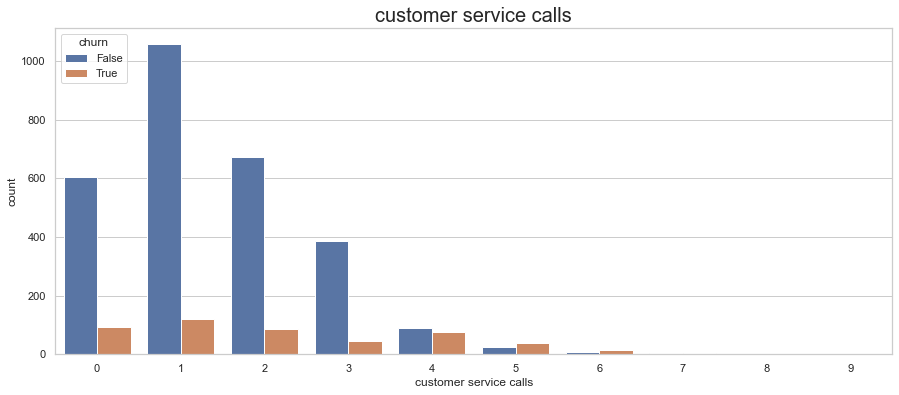

In [83]:
columns = ['state', 'area code', 'international plan', 'voice mail plan', 'customer service calls']
compare_with_target(columns)

In [84]:
pd.set_option('display.max_rows', 110)
df_state = pd.DataFrame(data.groupby('state').churn.value_counts(normalize=True).reset_index(name='count'))
df_state[(df_state['churn'] == True) & (df_state['count'] >= 0.25)]

,state,churn,count
9,CA,True,0.264706
63,NJ,True,0.264706
87,TX,True,0.250000


### Conclusion after visualization:
1. STATE - there is 3 state in which churn made 1 out of 4 customers (CA, NJ, TX) and 9 where 1 of 5 made churn.
2. Variable AREA CODE doesn't seem to make much different for cusotmers churn.
3. Variable INTERNATIONAL PLAN gives us hint about customers churn, because in case when customers have international plan, half of them made churn.
4. VOICE MAIL PLAN for the first glance only have small contribution in helping to understand customers churn. If there is voice mail plan then probabily of churn by cutomers is greater.
5. CUSTOMER SERVICE CALLS - we can try to make new variable where number of calls after 4 will be group together as '> 4'
6. Rows whose values are caught as outliers contain many customers who stay loyal to telco industry.

In [85]:
# Try to make new variable from CUSTOMER SERVICE CALLS

# create a list of our conditions
conditions = [
    (data['customer service calls'] == 0),
    (data['customer service calls'] == 1),
    (data['customer service calls'] == 2),
    (data['customer service calls'] == 3),
    (data['customer service calls'] == 4),
    (data['customer service calls'] >= 5)
    ]

# create a list of the values we want to assign for each condition
values = [0,1,2,3,4,5]#['0', '1', '2', '3', '4', '5']

# create a new column and use np.select to assign values to it using our lists as arguments
data['customer calls'] = np.select(conditions, values)

# display updated DataFrame
data.head(3)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,customer calls
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,16.78,244.7,91,11.01,10.0,3,2.70,1,False,1
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,16.62,254.4,103,11.45,13.7,3,3.70,1,False,1
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,10.30,162.6,104,7.32,12.2,5,3.29,0,False,0


In [86]:
data[(data['customer calls'] == 5)]['churn'].value_counts(normalize=True)

True     0.613861
False    0.386139
Name: churn, dtype: float64

#### Making 2 datasets:
- one with no changes -> data
- other with minor changes ( -> new_data):
    * dropping columns: 'phone number' and 'customer service calls'
    * makes new variable 'customer calls' from 'customer service calls'

In [87]:
new_data = data.copy()
new_data.drop(['phone number', 'customer service calls'], axis=1, inplace=True)

### Correlation and minor modification of data (using data without changes)

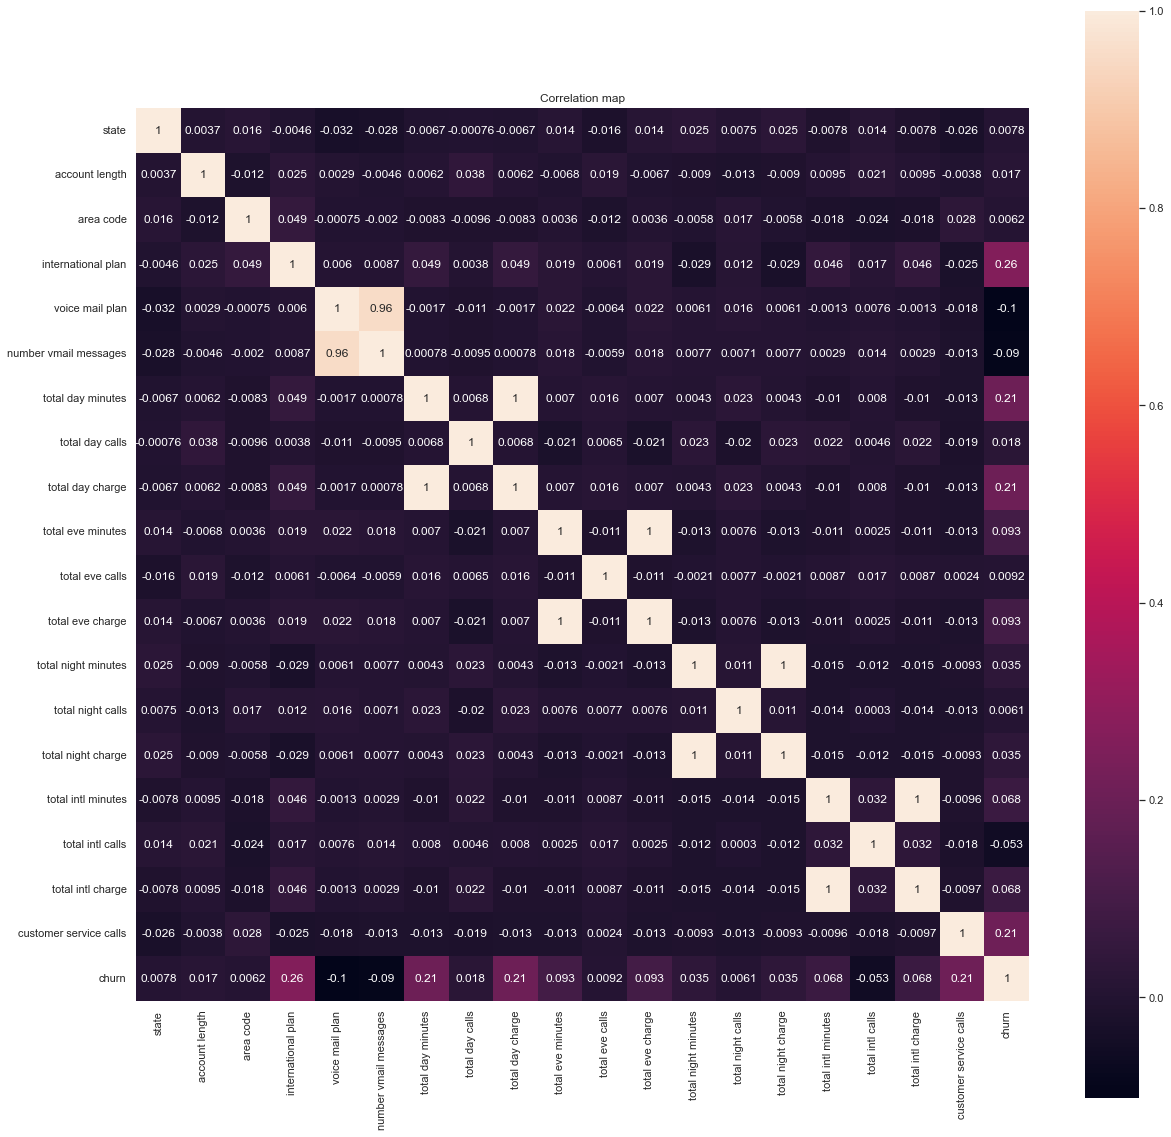

In [88]:
X, y = basic_preprocess(data=data, 
                        target='churn', 
                        plot_corr='yes', 
                        col_to_drop=['phone number', 'customer calls'], 
                        divide='yes')

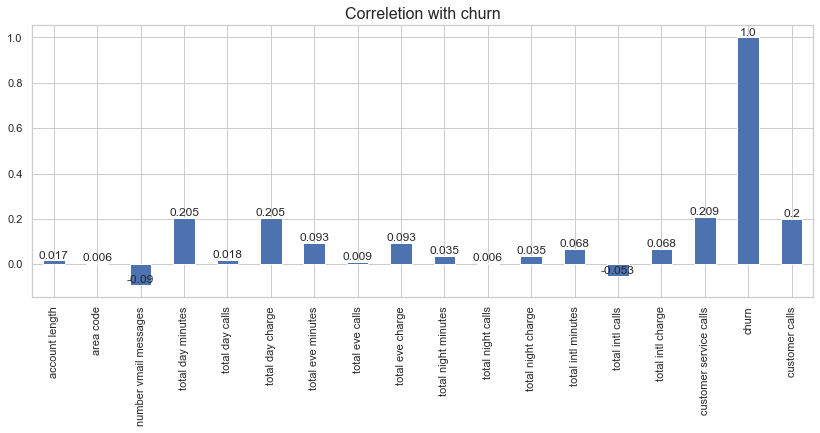

In [89]:
corr_plot(data, 'churn')

## 5. Feature selection and dimension reduction

In [114]:
normalizer = Normalizer()
standarizer = StandardScaler()
minmaxscaler = MinMaxScaler()

#### Selecting features by few methods:

In [117]:
# How many features we want to select:
X = X
y = y
feature_name = list(X.columns)
num_feats = 12

# Pearson correlation feature:
cor_support, cor_feature = pearson_cor_selector(X, y, num_feats)

# Chi-Square feature:
chi_support, chi_feature = chi_square_selector(X, y, minmaxscaler, num_feats)

# Recursive Feature Elimination:
rfe_support, rfe_feature = rfe_selector(X, y, minmaxscaler, num_feats)

# Lasso: SelectFromModel
l2_support, l2_feature = lr_lasso_selector(X, y, minmaxscaler, num_feats)

# Tree-based: SelectFromModel
tree_support, tree_feature = tree_selector(X, y, num_feats)

# Creating dataframe with outcomes:
feature_selection_df = print_feature_summary(feature_name, cor_support, chi_support, rfe_support, l2_support, tree_support)
feature_selection_df

Pearson correlation: 12 selected features
Chi-square: 12 selected features
Fitting estimator with 19 features.
RFE: 12 selected features
Lasso: 8 selected features
Tree: 6 selected features
Name of this dataframe: 'feature_selection_df'


C:\Users\admin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,total eve minutes,True,True,True,True,True,5
2,total eve charge,True,True,True,True,True,5
3,total day minutes,True,True,True,True,True,5
4,total day charge,True,True,True,True,True,5
5,international plan,True,True,True,True,True,5
6,customer service calls,True,True,True,True,True,5
7,voice mail plan,True,True,True,True,False,4
8,total intl calls,True,True,True,True,False,4
9,total intl minutes,True,True,True,False,False,3
10,total intl charge,True,True,True,False,False,3


#### Modify different dataset:

In [18]:
# Standarized(normalized) dataset:
X_normalized = preprocessing(X, preprocessor = normalizer)
X_stand = preprocessing(X, preprocessor=standarizer)

# dataset with only standarization(normalization):
X_all_normalized = X_stand
print(f"Dataset with all features after normalization has: {X_all_normalized.shape[1]} features.")

# dataset after PCA:
X_pca = data_after_pca(X_stand)
print(f"Dataset after PCA has: {X_pca.shape[1]} features.")

# dataset with selected feature by few methods together:
n = len(feature_selection_df.loc[feature_selection_df['Total'] > 2])
col_to_take = feature_selection_df['Feature'][:n]
X_selected = X[col_to_take]
X_normed = preprocessing(X_selected, preprocessor=standarizer)
X_selected_by_methods = X_normed
print(f"Dataset with selected feature by few methods together has: {X_selected_by_methods.shape[1]} features.")

# dataset without column with high correlation:
col_to_drop = col_to_drop_after_high_corr(data, 0.9)
col_to_stay = [col for col in X.columns if col not in col_to_drop]
X_new = X[col_to_stay]
X_norm = preprocessing(X_new, preprocessor=standarizer)
X_drop_high_corr = X_norm
print(f"Dataset without column which are higly correlated has: {X_drop_high_corr.shape[1]} features.")

# dataset after resampling:
y_res, X_res = resample_data(data=data, target='churn', col_to_drop = ['phone number'])

Dataset with all features after normalization has: 19 features.
Dataset after PCA has: 14 features.
Dataset with selected feature by few methods together has: 11 features.
Dataset without column which are higly correlated has: 15 features.
New dataset after resampling has: 1497 rows


#### Dividing different dataset on train and test set

In [19]:
# dataset with only standarization
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all_normalized, y, test_size=0.2, random_state=42, stratify = y)

# dataset after PCA:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify = y)

# dataset with selected feature by 5 methods together:
X_train_m5, X_test_m5, y_train_m5, y_test_m5 = train_test_split(X_selected_by_methods, y, test_size=0.2, random_state=42, stratify = y)

# dataset without column with high correlation:
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_drop_high_corr, y, test_size=0.2, random_state=42, stratify = y)

# dataset after resampling:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

### Methods to deal with unbalaced data

- SMOTE
- Resample

In [20]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

model = RandomForestClassifier()
params = {
    'clf__max_depth': [5, 7, 10],
    'clf__max_samples': [0.75, 1], 
    'clf__n_estimators': [100, 200, 300],
    'clf__min_samples_leaf': [1, 5]  
    }

### Score on resample data

In [21]:
# Resample data:
gs_resample = find_best_option(model, X_train_res, y_train_res, params = params)
print("Validation score for resample data: {:.2f}".format(gs_resample.score(X_test_res, y_test_res)))
gs_resample = find_best_option(model, X_train_res, y_train_res, balance=sm, params = params)
print("Validation score for resample data with smote: {:.2f}".format(gs_resample.score(X_test_res, y_test_res)))

Validation score for resample data: 0.87
Validation score for resample data with smote: 0.92


### Score on different data without smote method

In [23]:
# No balancing:
gs_all = find_best_option(model, X_train_all, y_train_all, params=params)
print("Validation score for all features: {:.2f}".format(gs_all.score(X_test, y_test)))

gs_pca = find_best_option(model, X_train_pca, y_train_pca, params = params)
print("Validation score for pca: {:.2f}".format(gs_pca.score(X_test_pca, y_test_pca)))

gs_m5 = find_best_option(model, X_train_m5, y_train_m5, params = params)
print("Validation score for 5 methods: {:.2f}".format(gs_m5.score(X_test_m5, y_test_m5)))

gs_corr = find_best_option(model, X_train_corr, y_train_corr, params = params)
print("Validation score for data without high corr columns: {:.2f}".format(gs_corr.score(X_test_corr, y_test_corr)))

Validation score for all features: 0.75
Validation score for pca: 0.39
Validation score for 5 methods: 0.79
Validation score for data without high corr columns: 0.70


### Score on different data using smote method

In [25]:
# With smote method:
gs_all = find_best_option(model, X_train_all, y_train_all, params=params, balance=sm)
print("Validation score for all features: {:.2f}".format(gs_all.score(X_test, y_test)))

gs_pca = find_best_option(model, X_train_pca, y_train_pca, params = params, balance=sm)
print("Validation score for pca: {:.2f}".format(gs_pca.score(X_test_pca, y_test_pca)))

gs_m5 = find_best_option(model, X_train_m5, y_train_m5, params=params, balance=sm)
print("Validation score for 5 methods: {:.2f}".format(gs_m5.score(X_test_m5, y_test_m5)))

gs_corr = find_best_option(model, X_train_corr, y_train_corr, params=params, balance=sm)
print("Validation score for data without high corr columcs: {:.2f}".format(gs_corr.score(X_test_corr, y_test_corr)))

Validation score for all features: 0.73
Validation score for pca: 0.60
Validation score for 5 methods: 0.73
Validation score for data without high corr columcs: 0.67


## 6. CLASSIFICATION
#### Selecting best models, best params and showing metrics

In [122]:
models_name = ['LogisticRegression', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier',\
               'GradientBoostingClassifier', 'KNeighborsClassifier', 'AdaBoostClassifier', 'XGBClassifier']

models = [
    Pipeline([("scaler", StandardScaler()), 
              ("clf", LogisticRegression(max_iter=1000))]),
    Pipeline([("scaler", StandardScaler()), 
              ("clf", SVC(kernel='rbf'))]),
    Pipeline([('clf', DecisionTreeClassifier())]),
    Pipeline([('clf', RandomForestClassifier())]),
    Pipeline([('clf', GradientBoostingClassifier())]),
    Pipeline([('clf', KNeighborsClassifier())]),
    Pipeline([('clf', AdaBoostClassifier())]),
    Pipeline([('clf', xgb.XGBClassifier())])
]

params = [
    {'clf__C': [0.1, 5, 10, 15],
    'clf__penalty': ['l2', 'none']},
    {"clf__C": [0.01, 0.1, 1, 10], 
     "clf__gamma": [0.1, 1, 10, 'scale', 'auto']},
    {"clf__min_samples_leaf": [1, 5],
     "clf__max_features": [0.75, 1],
     "clf__max_depth": [5,7,10],
     "clf__criterion": ['gini', 'entropy']},
    {"clf__n_estimators": [350, 400],
     "clf__min_samples_leaf": [1, 3],
     "clf__max_samples": [0.75, 1]},
    {"clf__n_estimators": [150, 200, 250],
     "clf__min_samples_leaf": [3, 5, 8, 10]},
    {"clf__n_neighbors": [5, 10, 15]},
    {"clf__n_estimators": [50,100]},
    {"clf__max_depth":  [4,5], 
     "clf__n_estimators": [250,300,350],
     "clf__subsample": [0.8, 0.85, 0.9],
     "clf__colsample_bytree": [0.75, 0.9],
     "clf__gamma": [0.1, 1, 3]}
]

In [132]:
metrics_value = looking_for_parameters(X, y, models, params, models_name)
metrics_value

Looking for best parameters for LogisticRegression
Done!
Looking for best parameters for SVC
Done!
Looking for best parameters for DecisionTreeClassifier
Done!
Looking for best parameters for RandomForestClassifier
Done!
Looking for best parameters for GradientBoostingClassifier
Done!
Looking for best parameters for KNeighborsClassifier
Done!
Looking for best parameters for AdaBoostClassifier
Done!
Looking for best parameters for XGBClassifier
Done!


,model_name,best_params,accuracy,precisionrecall,f1,mislabeled,total
0,LogisticRegression,"{'clf__C': 10, 'clf__penalty': 'l2'}",0.86,NaN,0.62,94,667
1,SVC,"{'clf__C': 10, 'clf__gamma': 'scale'}",0.91,NaN,0.79,62,667
2,DecisionTreeClassifier,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.93,NaN,0.85,47,667
3,RandomForestClassifier,"{'clf__max_samples': 0.75, 'clf__min_samples_l...",0.94,NaN,0.87,39,667
4,GradientBoostingClassifier,"{'clf__min_samples_leaf': 5, 'clf__n_estimator...",0.95,NaN,0.88,36,667
5,KNeighborsClassifier,{'clf__n_neighbors': 5},0.87,NaN,0.65,86,667
6,AdaBoostClassifier,{'clf__n_estimators': 100},0.86,NaN,0.68,92,667
7,XGBClassifier,"{'clf__colsample_bytree': 0.75, 'clf__gamma': ...",0.95,NaN,0.90,31,667


## 7. CROSS VAL SCORE

In [125]:
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [127]:
clf = {
    'LogisticRegression' :LogisticRegression(random_state=42), 
    'SVM': SVC(random_state=42), 
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42), 
    'RandomForestClassifier':RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42), 
    'KNeighborsClassifier': KNeighborsClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

#### Cross validation before tune (on default parameters):

In [128]:
df_cv_scores_before = cvs_scores_to_df(clf, 'f1', 0.1, sfk)
df_cv_scores_before.sort_values(by ='mean', ascending=False)

This function made dataframe with scores from different models through cross validation using f1 to score models.


,model,mean,min,max,overfitting
7,XGBoost,0.831560,0.785714,0.882682,No
3,RandomForestClassifier,0.810014,0.773006,0.839080,No
4,GradientBoostingClassifier,0.804690,0.775758,0.827586,No
2,DecisionTreeClassifier,0.707623,0.643216,0.753769,Yes
1,SVM,0.636831,0.619355,0.671053,No
5,KNeighborsClassifier,0.473140,0.439394,0.514286,No
6,AdaBoostClassifier,0.460523,0.386207,0.534161,Yes
0,LogisticRegression,0.297730,0.236220,0.391608,Yes


#### Cross validation after tune (using best parameters):

In [129]:
clf = {
    'LogisticRegression' :LogisticRegression(random_state=42), 
    'SVM': SVC(C=10, gamma='scale', random_state=42), 
    'DecisionTreeClassifier': DecisionTreeClassifier(min_samples_leaf=5, max_features=0.75, criterion='gini', max_depth=10, random_state=42), 
    'RandomForestClassifier':RandomForestClassifier(max_samples=0.75, n_estimators=400, min_samples_leaf=1, random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(min_samples_leaf=5, n_estimators=200, random_state=42), 
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(colsample_bytree=0.75, gamma=1, max_depth=5, n_estimators=300, subsample=0.85, random_state=42)
}

In [130]:
df_cv_scores_after = cvs_scores_to_df(clf, 'f1', 0.1, sfk)
df_cv_scores_after

This function made dataframe with scores from different models through cross validation using f1 to score models.


,model,mean,min,max,overfitting
0,LogisticRegression,0.297730,0.236220,0.391608,Yes
1,SVM,0.708230,0.681319,0.736264,No
2,DecisionTreeClassifier,0.791489,0.758621,0.815217,No
3,RandomForestClassifier,0.802541,0.753086,0.837209,No
4,GradientBoostingClassifier,0.817460,0.775758,0.849162,No
5,KNeighborsClassifier,0.473140,0.439394,0.514286,No
6,AdaBoostClassifier,0.460523,0.386207,0.534161,Yes
7,XGBoost,0.814683,0.785714,0.837989,No


## 8.
TO DO in 8:
1. Models with resampling data using best parameters
2. Models using smote 
3. Models with select from models

4. Metrics: precision vs recall -> resampling methods - zaawansowane problemy klasyfikacji
5. Conclusion


In [ ]:
model = xgb.XGBClassifier(**best_parameters, tree_method='gpu_hist')
model.fit(X_train, y_train)  
measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val)
measures

## 9. SUMMARY